In [1]:
%matplotlib inline

%load_ext autoreload

# Création de données synthétiques

In [2]:
import pointprocesses as ppr
import itertools
import numpy as np
import matplotlib.pyplot as plt

Le processus de Hawkes à noyau exponentiel est modélisé par
$$
    g(t) = \alpha\beta e^{-\beta t}
$$

In [3]:
def intensity_function_(t, lam0, alpha, beta, history):
    return lam0 + np.sum(alpha*beta*np.exp(-beta*(t - history))*(t >= history), axis=0)

intensity_function = np.vectorize(intensity_function_, excluded={4})

# Network design

On utilisera PyTorch pour réaliser notre réseau de neurones récursif (RNN).

In [741]:
import torch
import torch.nn as nn

### Bayesian network

Algorithme d'Ogata pour le calcul récursif de la fonction d'intensité $\lambda$:
$$
    \lambda_k = \lambda_0 + e^{-\beta(t_k-t_{k-1})}(\lambda_{k-1} - \lambda_0) + \alpha\beta \xi_k
$$
où $\xi_k = \xi(t_k)$ vaut 1 ssi il s'est produit un événement en $t_k$ et 0 sinon.

La probabilité qu'un événement se produise entre $t_{k-1}$ et $\Delta t$:
$$
    \mathbb P(t_k\in[t_{k-1}, t_{k-1} + \Delta t], \xi_k = 1\mid \mathcal H_{k-1}) = 1 - \exp\left(-(\lambda_{k-1} - \lambda_0)\left(\frac{1 - e^{-\beta\Delta t}}{\beta}\right) - \lambda_0\Delta t\right) := \mathcal L_k(\Delta t)
$$

En effet, $t_k$ suit conditionnellement une loi exponentielle de paramètre
$$
    \Lambda = \int_{t_{k-1}}^{t_k} \lambda_s\,\mathrm ds.
$$
et on peut utiliser la formule d'Ogata (qui est exacte) pour exprimer $\lambda_s$, le terme en $\xi(s)$ étant d'intégrale nulle.

On cherche le meilleur estimateur $\beta \in \{\beta_1,\ldots,\beta_p\}$ parmi des valeurs discrètes.

On peut utiliser un algorithme d'_inférence bayésienne_:
$$
    \mathbb P(\beta_j\mid \mathcal H_k) \sim \sum_{\xi_k\in\{0,1\}}\mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) \mathbb P(\beta_j\mid \mathcal H_{k-1})
$$
où 
$$
    \mathbb P(\xi_k, t_k\mid \mathcal H_{k-1},\beta_j) = \mathcal L_k^{(j)}(t_k - t_{k-1})\left(\lambda_0 + e^{-\beta_j(t_k - t_{k-1})}(\lambda_k^{(j)} - \lambda_0) \right)^{\xi_k}
$$
avec l'indice $(j)$ précisant que les valeurs sont calculées pour $\beta = \beta_j$.

In [872]:
%autoreload 2
from bayesianrnn import RNN

On crée un échantillon synthétique de $M= 1000$ trajectoires.

In [955]:
T = 60.0
alpha = 0.2
beta = 5.0 # real beta value
betas = torch.Tensor(np.linspace(0.0, 20.0, 11)[1:]).to(dtype=torch.float64)
lam0 = 1.0

print("Beta values to test:")
print(betas)
print("True value: %s" % beta)
print()

print("Avg. no. of events: %.3f" % (T*lam0/(1-alpha)))

n_samples = 3000
sample_data = [ppr.hawkes_exp(T, beta, lam0, itertools.repeat(alpha)) for _ in range(n_samples)]

p_betas = torch.ones_like(betas)/betas.shape[0]
print("Distribution of beta priors:")
print(p_betas)

Beta values to test:
tensor([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.], dtype=torch.float64)
True value: 5.0

Avg. no. of events: 75.000
Distribution of beta priors:
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000], dtype=torch.float64)


66


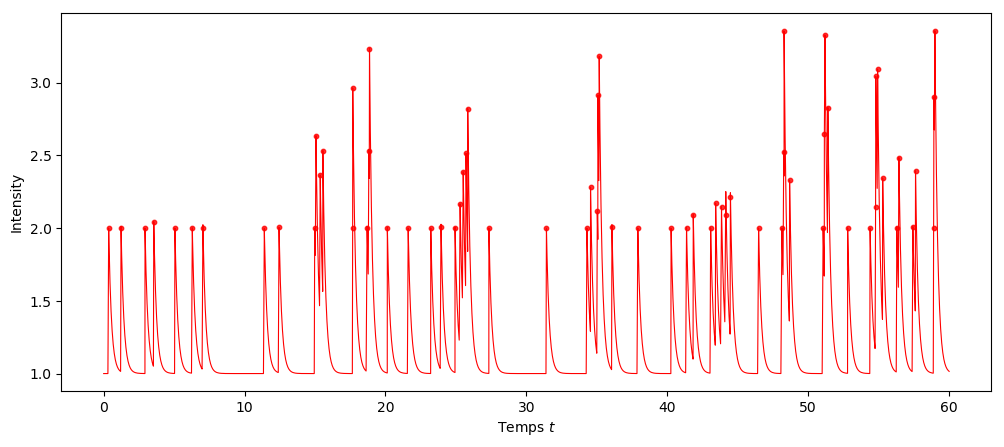

In [956]:
print(sample_data[0][:,0].size)

time_vals = np.sort(np.append(np.linspace(0, T, 800), sample_data[0][:,0]))

ints_proc = intensity_function(time_vals, lam0, alpha, beta, sample_data[0][:,0])

fig, ax = plt.subplots(1, 1, figsize=(12,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.set_ylabel("Intensity")
ax.scatter(sample_data[0][:,0], sample_data[0][:,1], c='r', s=10, alpha=0.8)
ax.plot(time_vals, ints_proc, 'r-', linewidth=0.8)

Les trajectoires simulées ont des longueurs différentes. On les prolonge suffisament et on les rassemble dans un tenseur.

In [957]:
input_size = max(s.shape[0] for s in sample_data)
print("Max. sequence size %d" % input_size)

arr = np.dstack([np.pad(a, ((input_size - a.shape[0],0),(0,0)), 'constant') for a in sample_data])
data_tensor = torch.from_numpy(arr)
print(data_tensor.shape)

Max. sequence size 114
torch.Size([114, 3, 3000])


### Training

In [958]:
def train(data_tensor):
    print("Train data shape: %s" % str(data_tensor.shape))
    hidden = net.initHidden()
    generated_sequence = []
    net.zero_grad()
    
    for i in range(data_tensor.size(0)):
        output, hidden = net(data_tensor[i], hidden)
        generated_sequence.append(output.view(1, -1))
    
    return torch.cat(generated_sequence)

In [974]:
net = RNN(n_samples, 10, n_samples, lam0, alpha, betas, p_betas)
net = net.to(device="cpu", dtype=torch.float64) # make sure the model uses doubles
print(net)

rnn_output = train(train_examples)

mu: 1.0
torch.Size([10])
torch.Size([1, 10])
RNN()
Train data shape: torch.Size([79, 13])


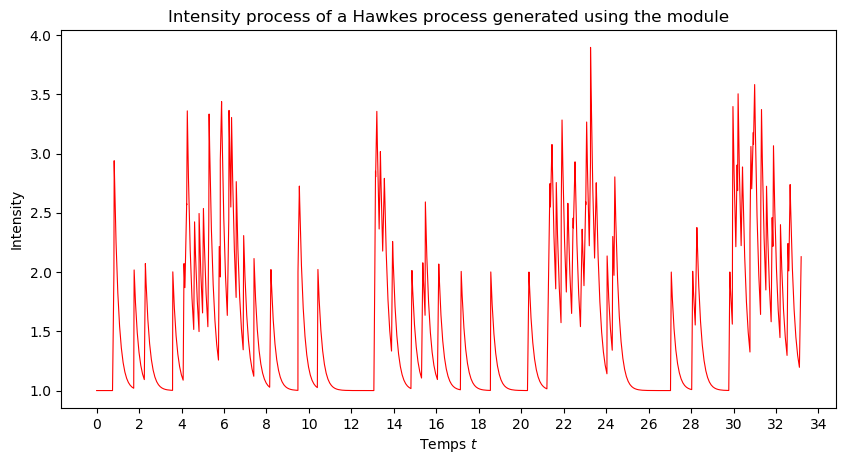

In [975]:
import matplotlib.ticker as mticker

tmax = rnn_output[:,0].max()
time_vals = np.sort(np.append(np.linspace(0, tmax, 400), rnn_output[:,0].numpy()))

ints_proc = intensity_function(time_vals, lam0, alpha, beta, rnn_output[:,0].numpy())

fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi=100)
ax.set_xlabel("Temps $t$")
ax.xaxis.set_major_locator(mticker.MultipleLocator(2.0))
ax.set_ylabel("Intensity")
ax.set_title("Intensity of process generated using the network")
ax.plot(time_vals, ints_proc, 'r-', linewidth=0.8)

In [976]:
print("Less likely beta: %s" % net.betas[net.beta_posts.argmin()])
print("Most likely beta: %s" % net.betas[net.beta_posts.argmax()])
print("Real beta %s" % beta)

Less likely beta: tensor(4., dtype=torch.float64)
Most likely beta: tensor(18., dtype=torch.float64)
Real beta 5.0


In [977]:
net.beta_posts.tolist()

[3.342142448669437e-16,
 1.1232874883182677e-17,
 4.0933655980368993e-16,
 1.6597772613952651e-09,
 1.830468968758809e-07,
 5.733441417909617e-11,
 3.5499781810671966e-13,
 6.528417546433355e-07,
 0.9998958736477034,
 0.00010328874617766849]